In [5]:
import numpy as np
import pandas as pd
import pickle

import h2o

In [9]:
%%bash
ls pkls/

X_train_test_y_train_test.pkl
cardiac_arrest_dfs.pkl
dem_hosp_dx_proc_orig_X_dfs.pkl
full_X_y_df.pkl
logr_tree_forest_gridsearch.pkl
logr_tree_forest_svc_gridsearch.pkl
master_influenza_df.pkl
scaled_X_train_test_y_train_test.pkl
svm_logr_tree_forest_mlp_gridsearch.pkl


In [10]:
with open('pkls/full_X_y_df.pkl', 'rb') as picklefile:
    [X, y] = pickle.load(picklefile)

In [152]:
with open('pkls/scaled_X_train_test_y_train_test.pkl', 'rb') as picklefile:
    [X_train_pandas, X_test_pandas, y_train_pandas, y_test_pandas] = pickle.load(picklefile)

In [39]:
print(X.shape)
X.head()

(12704, 193)


,discharge,thcic_id,provider_name,type_of_admission,source_of_admission,spec_unit_1,spec_unit_2,spec_unit_3,spec_unit_4,spec_unit_5,...,risk_mortality,illness_severity,apr_grouper_version_nbr,apr_grouper_error_code,attending_physician_unif_id,operating_physician_unif_id,encounter_indicator,cert_status,filler_space,hiv_drug
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,2011Q1,829900,North Austin Medical Center,1,1,None,None,None,None,None,...,3,3,07280,00,7551845610,None,01,1,None,0
120110922505,2011Q1,829900,North Austin Medical Center,1,5,I,None,None,None,None,...,3,4,07280,00,6054383818,8034945272,01,1,None,0
120110921645,2011Q1,829900,North Austin Medical Center,1,1,I,None,None,None,None,...,4,4,07280,00,6054383818,9800701308,01,1,None,0
120110919484,2011Q1,829900,North Austin Medical Center,1,1,I,None,None,None,None,...,2,3,07280,00,2876967896,3108526421,01,1,None,0
120110919499,2011Q1,829900,North Austin Medical Center,1,1,I,None,None,None,None,...,4,4,07280,00,4678321056,3418726242,01,1,None,0


The overall idea of this notebook is to try out H2O and see whether it does a better job with classification, particularly since the vast majority of your variables are categorical, whether or not the decision trees in particular do better.

Therefore, I think that I still have to clean up the 4 categories of variables, but I won't have to dummify all of them. I do think that I have to continue to use the most common diagnoses/procedures as boolean flags.

In [23]:
# We'll define the four categories of predictors here.

target = 'pat_status'

index = 'record_id'

personal_demographic_predictors = ['pat_age', 'sex_code', 'race', 'ethnicity', 'public_health_region', 'first_payment_src', 'secondary_payment_src']
hospital_stay_predictors = ['provider_name', 'type_of_admission', 'source_of_admission', 'admit_weekday', 'length_of_stay']

diag_codes_predictors = ['admitting_diagnosis']
diag_codes_predictors.extend([col for col in master_2011_df.columns if 'diag_code' in col])

e_code_predictors = [col for col in master_2011_df.columns if 'e_code' in col]

proc_code_predictors = ['princ_surg_proc_code', 'princ_surg_proc_day', 'princ_icd9_code']
proc_code_predictors.extend([col for col in master_2011_df.columns if 'oth_surg' in col or 'oth_icd9' in col])

### Demographic predictors

In [14]:
X[personal_demographic_predictors].head()

,pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src
record_id,,,,,,,
120110921391,20,M,4,2,07,MA,CH
120110922505,11,F,3,2,07,MA,MC
120110921645,17,F,4,2,07,MA,CH
120110919484,19,F,4,2,07,16,None
120110919499,16,M,5,1,07,MA,12


In [15]:
# First we need to make X['pat_age'] numeric.
X['pat_age'] = X['pat_age'].apply(pd.to_numeric)

# Now create a binary variable called 'hiv_drug' and initialize it to 0 for all patients.
X['hiv_drug'] = 0

# For every row where 'pat_age' is greater than 21, set the hiv_drug flag to drue.
X.loc[X['pat_age'] > 21, 'hiv_drug'] = 1

# Now replace the patient ages for the hiv_drug patients with an approximate mapping to another age category.
age_replace_dict = {22: 5, 23: 9, 24: 14, 25: 17, 26: 18}

X = X.replace({'pat_age': age_replace_dict})

In [18]:
personal_demographic_predictors.append('hiv_drug')

In [19]:
X[personal_demographic_predictors].head()

,pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src,hiv_drug
record_id,,,,,,,,
120110921391,20,M,4,2,07,MA,CH,0
120110922505,11,F,3,2,07,MA,MC,0
120110921645,17,F,4,2,07,MA,CH,0
120110919484,19,F,4,2,07,16,None,0
120110919499,16,M,5,1,07,MA,12,0


In [20]:
X_demographics_df = X[personal_demographic_predictors]

### Hospital stay predictors

In [24]:
X[hospital_stay_predictors].head()

,provider_name,type_of_admission,source_of_admission,admit_weekday,length_of_stay
record_id,,,,,
120110921391,North Austin Medical Center,1,1,1,0004
120110922505,North Austin Medical Center,1,5,2,0006
120110921645,North Austin Medical Center,1,1,5,0004
120110919484,North Austin Medical Center,1,1,1,0006
120110919499,North Austin Medical Center,1,1,1,0019


In [25]:
facilities_q1 = pd.read_csv("data/texas/Facility_type1q2011_tab.txt", sep="\t")
teaching_hospitals_tx = list(facilities_q1['PROVIDER_NAME'][~facilities_q1['FAC_TEACHING_IND'].isnull()])

CAH_hospitals_from_web = pd.read_excel('data/texas/2011-Mar-CAH-List.xls')
CAH_hospitals_texas_from_web = CAH_hospitals_from_web[CAH_hospitals_from_web['CAHSTATE'] == 'TX']
CAH_texas = list(set(facilities_q1['PROVIDER_NAME']).intersection(set(CAH_hospitals_texas_from_web['CAHNAME'])))

In [26]:
X_hospital_df = X[hospital_stay_predictors].copy()

In [36]:
hospital_type = []

for i in range(X['provider_name'].shape[0]):
    if X_hospital_df['provider_name'][i] in teaching_hospitals_tx:
        hospital_type.append("teaching")
    elif X_hospital_df['provider_name'][i] in CAH_texas:
        hospital_type.append("rural")
    else:
        hospital_type.append("community")

In [42]:
X_hospital_df['hospital_type'] = hospital_type
X_hospital_df.drop(['provider_name'], axis=1, inplace=True)

In [44]:
# We'll make length of stay numeric.
X_hospital_df['length_of_stay'] = X_hospital_df['length_of_stay'].apply(pd.to_numeric)

In [45]:
X_hospital_df.head()

,type_of_admission,source_of_admission,admit_weekday,length_of_stay,hospital_type
record_id,,,,,
120110921391,1,1,1,4,community
120110922505,1,5,2,6,community
120110921645,1,1,5,4,community
120110919484,1,1,1,6,community
120110919499,1,1,1,19,community


Instead of re-processing the diagnoses and procedures dataframes, we'll go ahead and just load them from the pkl file. We'll ignore the dummified demographic and hospital dataframes.

In [46]:
with open('pkls/dem_hosp_dx_proc_orig_X_dfs.pkl', 'rb') as picklefile:
    [X_demographic_predictors_dummified, X_hospital_predictors_df, X_diagnoses_df, X_procedures_df, X] = pickle.load(picklefile)

In [47]:
X_diagnoses_df.head()

,"(51881, Y)","(4019, Y)","(4280, Y)","(41401, Y)","(2724, Y)","(25000, Y)","(5849, Y)","(3481, Y)","(2762, Y)","(42731, Y)",...,"(2760, N)","(78552, N)","(42741, N)","(42789, N)","(486, N)","(5180, N)","(78551, N)","(2851, N)","(5845, N)",out_of_hospital_cardiac_arrest
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110922505,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110921645,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
120110919499,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [48]:
X_procedures_df.head()

,9604,9671,9960,3893,9904,9672,3891,3995,8856,3722,...,3761,9390,8872,3607,0045,3324,4311,3404,3961,9915
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110922505,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110921645,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919484,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919499,1,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Merging dataframes

Now that we have the demographic, hospital, diagnoses and procedure dataframes all loaded, we can merge them into a single dataframe. Then we'll convert that dataframe into an H2O object, and then start running H2O classifier models on it.

In [49]:
from functools import reduce

In [52]:
dfs = [X_demographics_df, X_hospital_df, X_diagnoses_df, X_procedures_df]

X_h2o_pandas = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)

In [53]:
X_h2o_pandas.head()

,pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src,hiv_drug,type_of_admission,source_of_admission,...,3761,9390,8872,3607,0045,3324,4311,3404,3961,9915
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,20,M,4,2,07,MA,CH,0,1,1,...,0,0,0,0,0,0,0,0,0,0
120110922505,11,F,3,2,07,MA,MC,0,1,5,...,0,0,0,0,0,0,0,0,0,0
120110921645,17,F,4,2,07,MA,CH,0,1,1,...,0,0,0,0,0,0,0,0,0,0
120110919484,19,F,4,2,07,16,None,0,1,1,...,0,0,0,0,0,0,0,0,0,0
120110919499,16,M,5,1,07,MA,12,0,1,1,...,0,0,0,0,0,1,0,0,0,0


In [55]:
X_h2o_pandas['target'] = y

In [56]:
X_h2o_pandas.head()

,pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src,hiv_drug,type_of_admission,source_of_admission,...,9390,8872,3607,0045,3324,4311,3404,3961,9915,target
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,20,M,4,2,07,MA,CH,0,1,1,...,0,0,0,0,0,0,0,0,0,expired
120110922505,11,F,3,2,07,MA,MC,0,1,5,...,0,0,0,0,0,0,0,0,0,expired
120110921645,17,F,4,2,07,MA,CH,0,1,1,...,0,0,0,0,0,0,0,0,0,expired
120110919484,19,F,4,2,07,16,None,0,1,1,...,0,0,0,0,0,0,0,0,0,expired
120110919499,16,M,5,1,07,MA,12,0,1,1,...,0,0,0,0,1,0,0,0,0,expired


In [76]:
# H2O got mad when I tried to import the dataframe with tuples as column names, so we have to cast the tuples to
# strings and then we can import it into an h2o dataframe.

tuple_cols = [col for col in X_h2o_pandas.columns if type(col) == tuple]

str_tuple_cols = [str(tuple_col) for tuple_col in tuple_cols]

tuple_to_str_dict = dict(zip(tuple_cols, str_tuple_cols))

X_h2o_pandas.rename(columns=tuple_to_str_dict, inplace=True)

In [147]:
X_h2o_pandas.head()

,pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src,hiv_drug,type_of_admission,source_of_admission,...,9390,8872,3607,0045,3324,4311,3404,3961,9915,target
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,20,M,4,2,07,MA,CH,0,1,1,...,0,0,0,0,0,0,0,0,0,expired
120110922505,11,F,3,2,07,MA,MC,0,1,5,...,0,0,0,0,0,0,0,0,0,expired
120110921645,17,F,4,2,07,MA,CH,0,1,1,...,0,0,0,0,0,0,0,0,0,expired
120110919484,19,F,4,2,07,16,None,0,1,1,...,0,0,0,0,0,0,0,0,0,expired
120110919499,16,M,5,1,07,MA,12,0,1,1,...,0,0,0,0,1,0,0,0,0,expired


In [160]:
# We should make sure we are using the same rows for the training and test sets for the H2O algorithms that were
# used for sklearn, to make sure that these are actually comparable.

X_h2o_train_pandas = X_h2o_pandas.loc[X_train_pandas.index]
X_h2o_test_pandas = X_h2o_pandas.loc[X_test_pandas.index]

### Converting to an H2O dataframe

In [73]:
import h2o
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 mins 54 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_joycelee_lrtxf3
H2O cluster total nodes:,1
H2O cluster free memory:,898 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [164]:
X_h2o_train = h2o.H2OFrame(X_h2o_train_pandas)
X_h2o_test = h2o.H2OFrame(X_h2o_test_pandas)

/Users/joycelee/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [168]:
features = X_h2o_train.columns
features.remove('pat_age')
features.remove('length_of_stay')

for f in features:
    X_h2o_train[f] = X_h2o_train[f].asfactor()
    X_h2o_test[f] = X_h2o_test[f].asfactor()

features.append('pat_age')
features.append('length_of_stay')

In [171]:
X_h2o_train.shape

(10163, 82)

## Not matching X_train and X_test to sklearn train and test

This is code I wrote earlier that also performed a 80/20 train/test split, but it doesn't match the train and test sets that I used on the sklearn models.

In [77]:
X_h2o = h2o.H2OFrame(X_h2o_pandas)
X_h2o.head(5)

/Users/joycelee/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src,hiv_drug,type_of_admission,source_of_admission,admit_weekday,length_of_stay,hospital_type,"('51881', 'Y')","('4019', 'Y')","('4280', 'Y')","('41401', 'Y')","('2724', 'Y')","('25000', 'Y')","('5849', 'Y')","('3481', 'Y')","('2762', 'Y')","('42731', 'Y')","('0389', 'Y')","('2859', 'Y')","('99592', 'Y')","('40390', 'Y')","('5856', 'Y')","('486', 'Y')","('496', 'Y')","('3051', 'Y')","('2449', 'Y')","('51881', 'N')","('5849', 'N')","('2762', 'N')","('0389', 'N')","('99592', 'N')","('3481', 'N')","('2768', 'N')","('4271', 'N')","('5070', 'N')","('2760', 'N')","('78552', 'N')","('42741', 'N')","('42789', 'N')","('486', 'N')","('5180', 'N')","('78551', 'N')","('2851', 'N')","('5845', 'N')",out_of_hospital_cardiac_arrest,9604,9671,9960,3893,9904,9672,3891,3995,8856,3722,8853,0017,9907,3897,0066,3895,0040,9962,311,9905,3761,9390,8872,3607,0045,3324,4311,3404,3961,9915,target
20,M,4,2,7,MA,CH,0,1,1,1,4,community,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
11,F,3,2,7,MA,MC,0,1,5,2,6,community,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
17,F,4,2,7,MA,CH,0,1,1,5,4,community,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
19,F,4,2,7,16,,0,1,1,1,6,community,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
16,M,5,1,7,MA,12,0,1,1,1,19,community,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,expired


In [85]:
# Let's get a list of all of the columns, and we can drop the only 2 that are not actually categorical.
# Those two features are patient age, and length of stay. Everything else is categorical.
features = X_h2o.columns
features.remove('pat_age')
features.remove('length_of_stay')

In [87]:
len(features)

80

In [88]:
# Let's now loop through each column in the dataframe and cast them 'asfactor'. Once we're done, we'll add back
# pat_age and length_of_stay as features.

for f in features:
    X_h2o[f] = X_h2o[f].asfactor()

In [169]:
features.append('pat_age')
features.append('length_of_stay')

In [92]:
X_split = X_h2o.split_frame(ratios = [0.8], seed = 1234)

X_train = X_split[0] # Use 80% of the data for training
X_test = X_split[1] # Use 20% of the data for testing

In [95]:
X_train.head()

pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src,secondary_payment_src,hiv_drug,type_of_admission,source_of_admission,admit_weekday,length_of_stay,hospital_type,"('51881', 'Y')","('4019', 'Y')","('4280', 'Y')","('41401', 'Y')","('2724', 'Y')","('25000', 'Y')","('5849', 'Y')","('3481', 'Y')","('2762', 'Y')","('42731', 'Y')","('0389', 'Y')","('2859', 'Y')","('99592', 'Y')","('40390', 'Y')","('5856', 'Y')","('486', 'Y')","('496', 'Y')","('3051', 'Y')","('2449', 'Y')","('51881', 'N')","('5849', 'N')","('2762', 'N')","('0389', 'N')","('99592', 'N')","('3481', 'N')","('2768', 'N')","('4271', 'N')","('5070', 'N')","('2760', 'N')","('78552', 'N')","('42741', 'N')","('42789', 'N')","('486', 'N')","('5180', 'N')","('78551', 'N')","('2851', 'N')","('5845', 'N')",out_of_hospital_cardiac_arrest,9604,9671,9960,3893,9904,9672,3891,3995,8856,3722,8853,0017,9907,3897,0066,3895,0040,9962,311,9905,3761,9390,8872,3607,0045,3324,4311,3404,3961,9915,target
20,M,4,2,7,MA,CH,0,1,1,1,4,community,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
11,F,3,2,7,MA,MC,0,1,5,2,6,community,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
17,F,4,2,7,MA,CH,0,1,1,5,4,community,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
16,M,5,1,7,MA,12,0,1,1,1,19,community,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,expired
18,M,5,2,7,MC,,0,1,1,6,4,community,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
17,F,2,2,7,MA,MC,0,1,1,1,3,community,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
18,M,4,2,7,MA,15,0,1,1,2,4,community,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
15,F,4,2,7,HM,,0,3,1,3,20,community,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
20,F,4,2,7,16,,0,1,1,2,7,community,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired
13,F,3,2,7,MA,MC,0,1,1,3,6,community,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,expired


### Generalized Linear Model

So we'll try our first binary classifier model and see how it works.

In [173]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# Set up GLM for binary classification
glm_default = H2OGeneralizedLinearEstimator(family = 'binomial', model_id = 'glm_default')

# Use .train() to build the model
glm_default.train(x = features, 
                  y = 'target', 
                  training_frame = X_h2o_train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [174]:
glm_default

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_default


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1362422584763172
RMSE: 0.36911008991399463
LogLoss: 0.44013566695279716
Null degrees of freedom: 10162
Residual degrees of freedom: 10020
Null deviance: 12625.876604104356
Residual deviance: 8946.197566481498
AIC: 9232.197566481498
AUC: 0.865873367311087
Gini: 0.731746734622174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5054919775712597: 


,alive,expired,Error,Rate
alive,1753.0,1424.0,0.4482,(1424.0/3177.0)
expired,550.0,6436.0,0.0787,(550.0/6986.0)
Total,2303.0,7860.0,0.1942,(1974.0/10163.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5054920,0.8670349,242.0
max f2,0.2235899,0.9210385,331.0
max f0point5,0.7344630,0.8719934,149.0
max accuracy,0.6193892,0.8106858,199.0
max precision,0.9926955,1.0,0.0
max recall,0.0003097,1.0,399.0
max specificity,0.9926955,1.0,0.0
max absolute_mcc,0.6193892,0.5569775,199.0
max min_per_class_accuracy,0.7049322,0.7924420,162.0
max mean_per_class_accuracy,0.7113422,0.7929917,159.0


Gains/Lift Table: Avg response rate: 68.74 %, avg score: 68.74 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100364,0.9810428,1.4547667,1.4547667,1.0,0.9854972,1.0,0.9854972,0.0146006,0.0146006,45.4766676,45.4766676
,2,0.0200728,0.9755922,1.4262418,1.4405043,0.9803922,0.9781230,0.9901961,0.9818101,0.0143143,0.0289150,42.6241839,44.0504258
,3,0.0300108,0.9701549,1.4259594,1.4356878,0.9801980,0.9728194,0.9868852,0.9788328,0.0141712,0.0430862,42.5959415,43.5687769
,4,0.0400472,0.9662806,1.3834546,1.4225974,0.9509804,0.9682388,0.9778870,0.9761778,0.0138849,0.0569711,38.3454584,42.2597389
,5,0.0500836,0.9628600,1.4262418,1.4233277,0.9803922,0.9645668,0.9783890,0.9738511,0.0143143,0.0712854,42.6241839,42.3327711
,6,0.1000689,0.9458886,1.4204021,1.4218663,0.9763780,0.9543158,0.9773845,0.9640931,0.0709991,0.1422846,42.0402109,42.1866348
,7,0.1500541,0.9298420,1.4003561,1.4147010,0.9625984,0.9378695,0.9724590,0.9553576,0.0699971,0.2122817,40.0356112,41.4700971
,8,0.2000394,0.9132618,1.4032198,1.4118321,0.9645669,0.9214990,0.9704870,0.9468971,0.0701403,0.2824220,40.3219825,41.1832096
,9,0.3000098,0.8789625,1.3674234,1.3970341,0.9399606,0.8963404,0.9603149,0.9300504,0.1367020,0.4191240,36.7423401,39.7034053
,10,0.3999803,0.8370582,1.3287633,1.3799706,0.9133858,0.8588927,0.9485855,0.9122654,0.1328371,0.5519611,32.8763263,37.9970554



Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-08-06 13:43:50,0.000 sec,0,6312.9383021,0.6211688
,2018-08-06 13:43:51,0.273 sec,1,4648.1430834,0.4613554
,2018-08-06 13:43:51,0.361 sec,2,4486.6952400,0.4465584
,2018-08-06 13:43:51,0.429 sec,3,4473.4157010,0.4455988
,2018-08-06 13:43:51,0.536 sec,4,4473.0987832,0.4455931


Let's check the performance on the test data.

In [175]:
glm_default.model_performance(X_h2o_test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.14032361307530147
RMSE: 0.3745979352256249
LogLoss: 0.4512909956203296
Null degrees of freedom: 2540
Residual degrees of freedom: 2398
Null deviance: 3156.2625883945343
Residual deviance: 2293.460839742517
AIC: 2579.460839742517
AUC: 0.8563247683326148
Gini: 0.7126495366652297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5466623795176814: 


,alive,expired,Error,Rate
alive,486.0,308.0,0.3879,(308.0/794.0)
expired,183.0,1564.0,0.1048,(183.0/1747.0)
Total,669.0,1872.0,0.1932,(491.0/2541.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5466624,0.8643272,225.0
max f2,0.2396845,0.9180806,322.0
max f0point5,0.7397166,0.8692767,146.0
max accuracy,0.5957913,0.8095238,205.0
max precision,0.9933791,1.0,0.0
max recall,0.0002870,1.0,399.0
max specificity,0.9933791,1.0,0.0
max absolute_mcc,0.6924133,0.5536661,167.0
max min_per_class_accuracy,0.7086285,0.7882084,160.0
max mean_per_class_accuracy,0.6924133,0.7893975,167.0


Gains/Lift Table: Avg response rate: 68.75 %, avg score: 68.49 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102322,0.9815395,1.4544934,1.4544934,1.0,0.9876353,1.0,0.9876353,0.0148827,0.0148827,45.4493417,45.4493417
,2,0.0200708,0.9735389,1.4544934,1.4544934,1.0,0.9766807,1.0,0.9822654,0.0143102,0.0291929,45.4493417,45.4493417
,3,0.0303030,0.9695635,1.4544934,1.4544934,1.0,0.9715958,1.0,0.9786627,0.0148827,0.0440756,45.4493417,45.4493417
,4,0.0401417,0.9659419,1.3963137,1.4402337,0.96,0.9677227,0.9901961,0.9759813,0.0137378,0.0578134,39.6313681,44.0233678
,5,0.0503739,0.9623368,1.4544934,1.4431302,1.0,0.9640684,0.9921875,0.9735615,0.0148827,0.0726961,45.4493417,44.3130187
,6,0.1003542,0.9437842,1.4086826,1.4259739,0.9685039,0.9530396,0.9803922,0.9633408,0.0704064,0.1431025,40.8682601,42.5973939
,7,0.1503345,0.9282855,1.3743245,1.4088025,0.9448819,0.9352434,0.9685864,0.9539995,0.0686892,0.2117916,37.4324489,40.8802525
,8,0.2003148,0.9116336,1.3628718,1.3973424,0.9370079,0.9203646,0.9607073,0.9456073,0.0681168,0.2799084,36.2871785,39.7342399
,9,0.3002755,0.8776081,1.3571454,1.3839610,0.9330709,0.8948138,0.9515072,0.9286984,0.1356611,0.4155695,35.7145433,38.3960971
,10,0.4002361,0.8360561,1.2941556,1.3615317,0.8897638,0.8577634,0.9360865,0.9109821,0.1293646,0.5449342,29.4155560,36.1531694


### Distributed Random Forest

Let's see whether or not distributed random forest works better in h2o than it did in sklearn, since h2o can handle categorical variables without one hot encoding.

In [176]:
# Build a Distributed Random Forest (DRF) model with default settings

# Import the function for DRF
from h2o.estimators.random_forest import H2ORandomForestEstimator

# Set up DRF for regression
# Add a seed for reproducibility
drf_default = H2ORandomForestEstimator(model_id = 'drf_default', seed = 1234)

# Use .train() to build the model
drf_default.train(x = features, 
                  y = 'target', 
                  training_frame = X_h2o_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [179]:
# Check the DRF model summary
drf_default.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_default


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.13291631466115467
RMSE: 0.36457689814517136
LogLoss: 0.42319107048418836
Mean Per-Class Error: 0.20157845706251298
AUC: 0.8764747670618903
Gini: 0.7529495341237806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4953907340101627: 


,alive,expired,Error,Rate
alive,1793.0,1384.0,0.4356,(1384.0/3177.0)
expired,600.0,6386.0,0.0859,(600.0/6986.0)
Total,2393.0,7770.0,0.1952,(1984.0/10163.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4953907,0.8655462,259.0
max f2,0.2499607,0.9226763,346.0
max f0point5,0.6975690,0.8762835,173.0
max accuracy,0.5651978,0.8092099,228.0
max precision,0.9725306,0.9953315,21.0
max recall,0.0,1.0,399.0
max specificity,0.9999461,0.9996852,0.0
max absolute_mcc,0.6111991,0.5647648,209.0
max min_per_class_accuracy,0.6599457,0.7922568,189.0
max mean_per_class_accuracy,0.6975690,0.7984215,173.0


Gains/Lift Table: Avg response rate: 68.74 %, avg score: 69.35 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0104300,1.0,1.4410425,1.4410425,0.9905660,1.0,0.9905660,1.0,0.0150301,0.0150301,44.1042462,44.1042462
,2,0.0200728,0.9977325,1.4399221,1.4405043,0.9897959,0.9986736,0.9901961,0.9993628,0.0138849,0.0289150,43.9922118,44.0504258
,3,0.0300108,0.9953121,1.4547667,1.4452272,1.0,0.9965142,0.9934426,0.9984195,0.0144575,0.0433725,45.4766676,44.5227223
,4,0.0400472,0.9923362,1.4405043,1.4440436,0.9901961,0.9936342,0.9926290,0.9972202,0.0144575,0.0578299,44.0504258,44.4043580
,5,0.0500836,0.9900408,1.4405043,1.4433343,0.9901961,0.9912561,0.9921415,0.9960251,0.0144575,0.0722874,44.0504258,44.3334325
,6,0.1000689,0.9738819,1.4519030,1.4476144,0.9980315,0.9825207,0.9950836,0.9892795,0.0725737,0.1448612,45.1902962,44.7614431
,7,0.1500541,0.9508192,1.4318570,1.4423654,0.9842520,0.9625092,0.9914754,0.9803619,0.0715717,0.2164329,43.1856965,44.2365387
,8,0.2000394,0.9312323,1.4089473,1.4340150,0.9685039,0.9408430,0.9857354,0.9704870,0.0704266,0.2868594,40.8947253,43.4014963
,9,0.3000098,0.8884459,1.3960605,1.4213676,0.9596457,0.9107420,0.9770417,0.9505786,0.1395648,0.4264243,39.6060541,42.1367638
,10,0.3999803,0.8288315,1.3258995,1.3975065,0.9114173,0.8604138,0.9606396,0.9280429,0.1325508,0.5589751,32.5899549,39.7506487



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-06 13:46:20,0.065 sec,0.0,nan,nan,nan,nan,nan
,2018-08-06 13:46:21,0.548 sec,1.0,0.4916752,7.1132497,0.7038653,1.1913050,0.2580469
,2018-08-06 13:46:21,0.841 sec,2.0,0.4659318,5.8192520,0.7348658,1.2186599,0.2436615
,2018-08-06 13:46:22,1.550 sec,3.0,0.4574876,5.0998281,0.7436721,1.2312012,0.2460349
,2018-08-06 13:46:22,1.936 sec,4.0,0.4408832,4.2615281,0.7658287,1.2606979,0.2412214
---,---,---,---,---,---,---,---,---
,2018-08-06 13:46:24,3.719 sec,20.0,0.3808514,0.6710254,0.8451551,1.3748130,0.2142084
,2018-08-06 13:46:24,3.825 sec,21.0,0.3799210,0.6379690,0.8470004,1.3752091,0.2121421
,2018-08-06 13:46:24,3.947 sec,22.0,0.3790460,0.6154184,0.8484771,1.3726214,0.2103710
,2018-08-06 13:46:24,4.081 sec,23.0,0.3780334,0.5916415,0.8503186,1.3753642,0.2117485



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
length_of_stay,10492.3037109,1.0,0.1739404
public_health_region,3273.1721191,0.3119593,0.0542623
first_payment_src,2812.9252930,0.2680942,0.0466324
admit_weekday,2644.8869629,0.2520788,0.0438467
secondary_payment_src,2604.5104980,0.2482306,0.0431773
---,---,---,---
"('78551', 'N')",180.4840240,0.0172016,0.0029920
"('42741', 'N')",158.6694794,0.0151225,0.0026304
9915,153.3581390,0.0146163,0.0025424
9905,152.4604492,0.0145307,0.0025275



See the whole table with table.as_data_frame()


In [180]:
drf_default.model_performance(X_h2o_test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.13052612770435917
RMSE: 0.361283998682974
LogLoss: 0.4072932585405201
Mean Per-Class Error: 0.19571622601682048
AUC: 0.8828513507863066
Gini: 0.7657027015726132
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4524515431374312: 


,alive,expired,Error,Rate
alive,406.0,388.0,0.4887,(388.0/794.0)
expired,101.0,1646.0,0.0578,(101.0/1747.0)
Total,507.0,2034.0,0.1924,(489.0/2541.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4524515,0.8706691,275.0
max f2,0.2961316,0.9269603,336.0
max f0point5,0.6833477,0.8802771,176.0
max accuracy,0.5923272,0.8170012,215.0
max precision,0.9996233,1.0,0.0
max recall,0.0966667,1.0,389.0
max specificity,0.9996233,1.0,0.0
max absolute_mcc,0.5923272,0.5781811,215.0
max min_per_class_accuracy,0.6572858,0.7950773,187.0
max mean_per_class_accuracy,0.6833477,0.8042838,176.0


Gains/Lift Table: Avg response rate: 68.75 %, avg score: 68.91 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102322,0.9921872,1.4544934,1.4544934,1.0,0.9955185,1.0,0.9955185,0.0148827,0.0148827,45.4493417,45.4493417
,2,0.0200708,0.9883513,1.4544934,1.4544934,1.0,0.9902546,1.0,0.9929381,0.0143102,0.0291929,45.4493417,45.4493417
,3,0.0303030,0.9798901,1.4544934,1.4544934,1.0,0.9839821,1.0,0.9899140,0.0148827,0.0440756,45.4493417,45.4493417
,4,0.0401417,0.9768657,1.4544934,1.4544934,1.0,0.9783764,1.0,0.9870862,0.0143102,0.0583858,45.4493417,45.4493417
,5,0.0503739,0.9725557,1.4544934,1.4544934,1.0,0.9749709,1.0,0.9846253,0.0148827,0.0732685,45.4493417,45.4493417
,6,0.1003542,0.9548813,1.4430407,1.4487895,0.9921260,0.9632683,0.9960784,0.9739886,0.0721236,0.1453921,44.3040713,44.8789522
,7,0.1503345,0.9380228,1.4315880,1.4430707,0.9842520,0.9464444,0.9921466,0.9648313,0.0715512,0.2169433,43.1588009,44.3070694
,8,0.2003148,0.9185256,1.4201353,1.4373481,0.9763780,0.9281788,0.9882122,0.9556862,0.0709788,0.2879222,42.0135305,43.7348112
,9,0.3002755,0.8785085,1.3972299,1.4239929,0.9606299,0.8976294,0.9790301,0.9363593,0.1396680,0.4275902,39.7229897,42.3992900
,10,0.4002361,0.8188476,1.3399664,1.4030069,0.9212598,0.8501854,0.9646018,0.9148370,0.1339439,0.5615341,33.9966377,40.3006925


### Gradient Boosting Machines

In [196]:
# Build a Gradient Boosting Machines (GBM) model with default settings

# Import the function for GBM
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Set up GBM for regression
# Add a seed for reproducibility
gbm_default = H2OGradientBoostingEstimator(model_id = 'gbm_default', seed = 1234)

# Use .train() to build the model
gbm_default.train(x = features, 
                  y = 'target', 
                  training_frame = X_h2o_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [213]:
# Check the GBM model summary
print(gbm_default)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_default


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0944390381731494
RMSE: 0.3073093525637471
LogLoss: 0.3089477263370953
Mean Per-Class Error: 0.13751596001932365
AUC: 0.9414542471335945
Gini: 0.882908494267189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5051564490894828: 


,alive,expired,Error,Rate
alive,2400.0,777.0,0.2446,(777.0/3177.0)
expired,498.0,6488.0,0.0713,(498.0/6986.0)
Total,2898.0,7265.0,0.1255,(1275.0/10163.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5051564,0.9105326,231.0
max f2,0.2789944,0.9443079,312.0
max f0point5,0.6880869,0.9200445,161.0
max accuracy,0.5152613,0.8747417,226.0
max precision,0.9878153,1.0,0.0
max recall,0.1120865,1.0,375.0
max specificity,0.9878153,1.0,0.0
max absolute_mcc,0.5152613,0.7042729,226.0
max min_per_class_accuracy,0.6234112,0.8596160,186.0
max mean_per_class_accuracy,0.6381149,0.8624840,181.0


Gains/Lift Table: Avg response rate: 68.74 %, avg score: 68.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100364,0.9848947,1.4547667,1.4547667,1.0,0.9862319,1.0,0.9862319,0.0146006,0.0146006,45.4766676,45.4766676
,2,0.0200728,0.9835505,1.4547667,1.4547667,1.0,0.9841480,1.0,0.9851900,0.0146006,0.0292013,45.4766676,45.4766676
,3,0.0300108,0.9826220,1.4547667,1.4547667,1.0,0.9830951,1.0,0.9844963,0.0144575,0.0436587,45.4766676,45.4766676
,4,0.0400472,0.9817073,1.4547667,1.4547667,1.0,0.9821031,1.0,0.9838965,0.0146006,0.0582594,45.4766676,45.4766676
,5,0.0500836,0.9810643,1.4547667,1.4547667,1.0,0.9813937,1.0,0.9833950,0.0146006,0.0728600,45.4766676,45.4766676
,6,0.1000689,0.9771669,1.4547667,1.4547667,1.0,0.9791772,1.0,0.9812882,0.0727169,0.1455769,45.4766676,45.4766676
,7,0.1500541,0.9725342,1.4547667,1.4547667,1.0,0.9749411,1.0,0.9791739,0.0727169,0.2182937,45.4766676,45.4766676
,8,0.2000394,0.9660890,1.4433118,1.4519044,0.9921260,0.9695962,0.9980325,0.9767806,0.0721443,0.2904380,44.3311820,45.1904371
,9,0.3000098,0.9408354,1.4504711,1.4514268,0.9970472,0.9553942,0.9977042,0.9696542,0.1450043,0.4354423,45.0471105,45.1426772
,10,0.3999803,0.8905366,1.4089473,1.4408095,0.9685039,0.9189544,0.9904059,0.9569824,0.1408531,0.5762954,40.8947253,44.0809505



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-06 13:51:43,0.053 sec,0.0,0.4635547,0.6211688,0.5,1.0,0.3126045
,2018-08-06 13:51:43,0.198 sec,1.0,0.4463116,0.5851255,0.8689622,1.4547667,0.1961035
,2018-08-06 13:51:44,0.279 sec,2.0,0.4317969,0.5561115,0.8738130,1.4493653,0.1907901
,2018-08-06 13:51:44,0.352 sec,3.0,0.4195353,0.5320968,0.8841745,1.4492631,0.1901013
,2018-08-06 13:51:44,0.418 sec,4.0,0.4091991,0.5121161,0.8849607,1.4492352,0.1882318
---,---,---,---,---,---,---,---,---
,2018-08-06 13:51:47,3.543 sec,46.0,0.3106062,0.3147997,0.9388062,1.4547667,0.1287022
,2018-08-06 13:51:47,3.612 sec,47.0,0.3096869,0.3132881,0.9394964,1.4547667,0.1268326
,2018-08-06 13:51:47,3.681 sec,48.0,0.3088219,0.3118517,0.9402585,1.4547667,0.1260455
,2018-08-06 13:51:47,3.744 sec,49.0,0.3080623,0.3104889,0.9408448,1.4547667,0.1264390



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
length_of_stay,3126.5046387,1.0,0.4962978
3722,364.5048218,0.1165854,0.0578611
out_of_hospital_cardiac_arrest,350.3861694,0.1120696,0.0556199
"('3481', 'Y')",200.7254944,0.0642012,0.0318629
8856,186.4668121,0.0596407,0.0295995
---,---,---,---
"('42741', 'N')",0.6089853,0.0001948,0.0000967
3404,0.5545451,0.0001774,0.0000880
hiv_drug,0.0,0.0,0.0
"('486', 'N')",0.0,0.0,0.0



See the whole table with table.as_data_frame()



In [198]:
# Check the model performance on test dataset
gbm_default.model_performance(X_h2o_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1164905505506734
RMSE: 0.34130712056837226
LogLoss: 0.3641625892590177
Mean Per-Class Error: 0.17327869727016743
AUC: 0.9040539449419588
Gini: 0.8081078898839176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43905947046472305: 


,alive,expired,Error,Rate
alive,491.0,303.0,0.3816,(303.0/794.0)
expired,132.0,1615.0,0.0756,(132.0/1747.0)
Total,623.0,1918.0,0.1712,(435.0/2541.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4390595,0.8813097,255.0
max f2,0.2713312,0.9279809,319.0
max f0point5,0.6189904,0.8941090,186.0
max accuracy,0.5408988,0.8327430,217.0
max precision,0.9868928,1.0,0.0
max recall,0.1081993,1.0,381.0
max specificity,0.9868928,1.0,0.0
max absolute_mcc,0.6189904,0.6266598,186.0
max min_per_class_accuracy,0.6258367,0.8236776,183.0
max mean_per_class_accuracy,0.6189904,0.8267213,186.0


Gains/Lift Table: Avg response rate: 68.75 %, avg score: 68.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102322,0.9846268,1.4544934,1.4544934,1.0,0.9860189,1.0,0.9860189,0.0148827,0.0148827,45.4493417,45.4493417
,2,0.0200708,0.9832434,1.4544934,1.4544934,1.0,0.9838839,1.0,0.9849723,0.0143102,0.0291929,45.4493417,45.4493417
,3,0.0303030,0.9821135,1.4544934,1.4544934,1.0,0.9826340,1.0,0.9841828,0.0148827,0.0440756,45.4493417,45.4493417
,4,0.0401417,0.9810799,1.4544934,1.4544934,1.0,0.9815005,1.0,0.9835253,0.0143102,0.0583858,45.4493417,45.4493417
,5,0.0503739,0.9801746,1.4544934,1.4544934,1.0,0.9806758,1.0,0.9829465,0.0148827,0.0732685,45.4493417,45.4493417
,6,0.1003542,0.9758728,1.4544934,1.4544934,1.0,0.9780478,1.0,0.9805068,0.0726961,0.1459645,45.4493417,45.4493417
,7,0.1503345,0.9701961,1.4430407,1.4506858,0.9921260,0.9734633,0.9973822,0.9781651,0.0721236,0.2180882,44.3040713,45.0685843
,8,0.2003148,0.9617361,1.4430407,1.4487783,0.9921260,0.9663156,0.9960707,0.9752085,0.0721236,0.2902118,44.3040713,44.8778315
,9,0.3002755,0.9353673,1.4201353,1.4392432,0.9763780,0.9501009,0.9895151,0.9668503,0.1419576,0.4321694,42.0135305,43.9243159
,10,0.4002361,0.8780865,1.3800508,1.4244596,0.9488189,0.9082715,0.9793510,0.9522200,0.1379508,0.5701202,38.0050841,42.4459630


So gradient boosted trees in H2O appears to have the best performance, with an AUC of 91% even on the the test set. So let's do a couple things: let's plot the ROC curve, and let's also figure out how to actually get a prediction out of the fitted/trained model given a particular input.

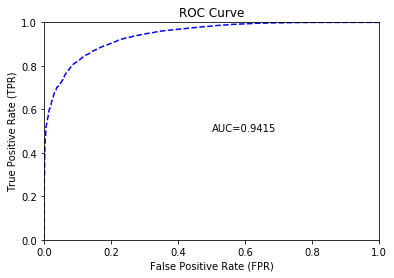

In [184]:
perf = gbm_default.model_performance(train=True)
perf.plot()

In [199]:
y_gbm_test_pred = gbm_default.predict(X_h2o_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [200]:
y_gbm_test_pred_df = y_gbm_test_pred.as_data_frame()

In [201]:
y_gbm_test_pred_df.head()

,predict,alive,expired
0,alive,0.815967,0.184033
1,expired,0.051861,0.948139
2,expired,0.180125,0.819875
3,expired,0.057768,0.942232
4,expired,0.195606,0.804394


In [202]:
y_test_df = X_h2o_test['target']

In [203]:
y_test = y_test_df.as_data_frame()

In [204]:
y_h2o_test_df = pd.merge(y_test, y_gbm_test_pred_df, left_index=True, right_index=True)

In [210]:
y_h2o_test_df.head()

,target,predict,alive,expired
0,alive,alive,0.815967,0.184033
1,expired,expired,0.051861,0.948139
2,alive,expired,0.180125,0.819875
3,expired,expired,0.057768,0.942232
4,expired,expired,0.195606,0.804394


In [206]:
with open("pkls/y_h2o_test_dft.pkl", "wb") as picklefile:
    pickle.dump(y_h2o_test_df, picklefile)

In [229]:
# Let's fit the gradient boosted model on the entire dataframe.

X_h2o_full = X_h2o_train.rbind(X_h2o_test)

In [231]:
gbm_default.train(x = features, 
                  y = 'target', 
                  training_frame = X_h2o_full)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [232]:
gbm_default.model_performance(X_h2o_full)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.09712622665435224
RMSE: 0.31165080884597784
LogLoss: 0.31557081421774
Mean Per-Class Error: 0.14540842786602726
AUC: 0.9368885861866446
Gini: 0.8737771723732892
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4991302177371535: 


,alive,expired,Error,Rate
alive,2942.0,1029.0,0.2591,(1029.0/3971.0)
expired,661.0,8072.0,0.0757,(661.0/8733.0)
Total,3603.0,9101.0,0.133,(1690.0/12704.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4991302,0.9052372,231.0
max f2,0.2868267,0.9429978,310.0
max f0point5,0.7223702,0.9150890,144.0
max accuracy,0.5186701,0.8672859,223.0
max precision,0.9874835,1.0,0.0
max recall,0.1479638,1.0,363.0
max specificity,0.9874835,1.0,0.0
max absolute_mcc,0.5821944,0.6914990,200.0
max min_per_class_accuracy,0.6269633,0.8534374,183.0
max mean_per_class_accuracy,0.6130651,0.8545916,189.0


Gains/Lift Table: Avg response rate: 68.74 %, avg score: 68.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100756,0.9849621,1.4547120,1.4547120,1.0,0.9861395,1.0,0.9861395,0.0146570,0.0146570,45.4712012,45.4712012
,2,0.0200724,0.9836541,1.4547120,1.4547120,1.0,0.9842738,1.0,0.9852103,0.0145425,0.0291996,45.4712012,45.4712012
,3,0.0300693,0.9826020,1.4547120,1.4547120,1.0,0.9831187,1.0,0.9845149,0.0145425,0.0437421,45.4712012,45.4712012
,4,0.0400661,0.9816364,1.4547120,1.4547120,1.0,0.9820714,1.0,0.9839052,0.0145425,0.0582847,45.4712012,45.4712012
,5,0.0500630,0.9807899,1.4547120,1.4547120,1.0,0.9812196,1.0,0.9833690,0.0145425,0.0728272,45.4712012,45.4712012
,6,0.1000472,0.9768115,1.4547120,1.4547120,1.0,0.9788421,1.0,0.9811073,0.0727127,0.1455399,45.4712012,45.4712012
,7,0.1500315,0.9712510,1.4547120,1.4547120,1.0,0.9740647,1.0,0.9787610,0.0727127,0.2182526,45.4712012,45.4712012
,8,0.2000157,0.9636824,1.4501302,1.4535670,0.9968504,0.9676483,0.9992129,0.9759839,0.0724837,0.2907363,45.0130242,45.3567020
,9,0.2999843,0.9396625,1.4444030,1.4505132,0.9929134,0.9534362,0.9971136,0.9684700,0.1443948,0.4351311,44.4403029,45.0513158
,10,0.4000315,0.8889714,1.4032077,1.4386821,0.9645948,0.9186407,0.9889807,0.9560078,0.1403870,0.5755181,40.3207653,43.8682127


In [233]:
y_gbm_full_pred = gbm_default.predict(X_h2o_full)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [234]:
y_gbm_full_pred

predict,alive,expired
expired,0.0760901,0.92391
alive,0.758762,0.241238
expired,0.0651211,0.934879
expired,0.0225862,0.977414
alive,0.704043,0.295957
expired,0.0141014,0.985899
alive,0.667004,0.332996
alive,0.631841,0.368159
expired,0.0661443,0.933856
expired,0.325993,0.674007


In [240]:
y_full_real = X_h2o_full['target']

In [247]:
y_full_real_df = y_full_real.as_data_frame()
y_gbm_full_pred_df = y_gbm_full_pred.as_data_frame()

In [248]:
y_h2o_full_df = pd.merge(y_full_real, y_gbm_full_pred_df, left_index=True, right_index=True)

In [249]:
y_h2o_full_df.head()

,target,predict,alive,expired
0,expired,expired,0.076090,0.923910
1,alive,alive,0.758762,0.241238
2,expired,expired,0.065121,0.934879
3,expired,expired,0.022586,0.977414
4,alive,alive,0.704043,0.295957


In [250]:
with open("pkls/y_h2o_full_df.pkl", "wb") as picklefile:
    pickle.dump(y_h2o_full_df, picklefile)

## Tuning gradient boosted tree

From this [link](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb)

In [215]:
# Set up GBM for regression
# Add a seed for reproducibility
gbm_cv = H2OGradientBoostingEstimator(model_id = 'gbm_default', seed = 2468, nfolds=4)

# Use .train() to build the model
gbm_cv.train(x = features, 
                  y = 'target', 
                  training_frame = X_h2o_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [216]:
gbm_cv

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_default


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0944390381731494
RMSE: 0.3073093525637471
LogLoss: 0.3089477263370953
Mean Per-Class Error: 0.13751596001932365
AUC: 0.9414542471335945
Gini: 0.882908494267189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5051564490894828: 


,alive,expired,Error,Rate
alive,2400.0,777.0,0.2446,(777.0/3177.0)
expired,498.0,6488.0,0.0713,(498.0/6986.0)
Total,2898.0,7265.0,0.1255,(1275.0/10163.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5051564,0.9105326,231.0
max f2,0.2789944,0.9443079,312.0
max f0point5,0.6880869,0.9200445,161.0
max accuracy,0.5152613,0.8747417,226.0
max precision,0.9878153,1.0,0.0
max recall,0.1120865,1.0,375.0
max specificity,0.9878153,1.0,0.0
max absolute_mcc,0.5152613,0.7042729,226.0
max min_per_class_accuracy,0.6234112,0.8596160,186.0
max mean_per_class_accuracy,0.6381149,0.8624840,181.0


Gains/Lift Table: Avg response rate: 68.74 %, avg score: 68.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100364,0.9848947,1.4547667,1.4547667,1.0,0.9862319,1.0,0.9862319,0.0146006,0.0146006,45.4766676,45.4766676
,2,0.0200728,0.9835505,1.4547667,1.4547667,1.0,0.9841480,1.0,0.9851900,0.0146006,0.0292013,45.4766676,45.4766676
,3,0.0300108,0.9826220,1.4547667,1.4547667,1.0,0.9830951,1.0,0.9844963,0.0144575,0.0436587,45.4766676,45.4766676
,4,0.0400472,0.9817073,1.4547667,1.4547667,1.0,0.9821031,1.0,0.9838965,0.0146006,0.0582594,45.4766676,45.4766676
,5,0.0500836,0.9810643,1.4547667,1.4547667,1.0,0.9813937,1.0,0.9833950,0.0146006,0.0728600,45.4766676,45.4766676
,6,0.1000689,0.9771669,1.4547667,1.4547667,1.0,0.9791772,1.0,0.9812882,0.0727169,0.1455769,45.4766676,45.4766676
,7,0.1500541,0.9725342,1.4547667,1.4547667,1.0,0.9749411,1.0,0.9791739,0.0727169,0.2182937,45.4766676,45.4766676
,8,0.2000394,0.9660890,1.4433118,1.4519044,0.9921260,0.9695962,0.9980325,0.9767806,0.0721443,0.2904380,44.3311820,45.1904371
,9,0.3000098,0.9408354,1.4504711,1.4514268,0.9970472,0.9553942,0.9977042,0.9696542,0.1450043,0.4354423,45.0471105,45.1426772
,10,0.3999803,0.8905366,1.4089473,1.4408095,0.9685039,0.9189544,0.9904059,0.9569824,0.1408531,0.5762954,40.8947253,44.0809505




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.11606444829282868
RMSE: 0.34068232753230493
LogLoss: 0.36363384779693025
Mean Per-Class Error: 0.17421571412981995
AUC: 0.9041171060138173
Gini: 0.8082342120276347
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4548966014056997: 


,alive,expired,Error,Rate
alive,2006.0,1171.0,0.3686,(1171.0/3177.0)
expired,553.0,6433.0,0.0792,(553.0/6986.0)
Total,2559.0,7604.0,0.1696,(1724.0/10163.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4548966,0.8818369,248.0
max f2,0.2478659,0.9276981,324.0
max f0point5,0.7221679,0.8956434,144.0
max accuracy,0.5393534,0.8333169,217.0
max precision,0.9888706,1.0,0.0
max recall,0.0654062,1.0,392.0
max specificity,0.9888706,1.0,0.0
max absolute_mcc,0.6109604,0.6194312,188.0
max min_per_class_accuracy,0.6400462,0.8199559,177.0
max mean_per_class_accuracy,0.6921003,0.8257843,156.0


Gains/Lift Table: Avg response rate: 68.74 %, avg score: 68.78 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100364,0.9853128,1.4547667,1.4547667,1.0,0.9867262,1.0,0.9867262,0.0146006,0.0146006,45.4766676,45.4766676
,2,0.0200728,0.9839616,1.4547667,1.4547667,1.0,0.9846013,1.0,0.9856638,0.0146006,0.0292013,45.4766676,45.4766676
,3,0.0300108,0.9829265,1.4547667,1.4547667,1.0,0.9834377,1.0,0.9849266,0.0144575,0.0436587,45.4766676,45.4766676
,4,0.0400472,0.9820655,1.4547667,1.4547667,1.0,0.9824733,1.0,0.9843118,0.0146006,0.0582594,45.4766676,45.4766676
,5,0.0500836,0.9812517,1.4547667,1.4547667,1.0,0.9816586,1.0,0.9837801,0.0146006,0.0728600,45.4766676,45.4766676
,6,0.1000689,0.9772387,1.4547667,1.4547667,1.0,0.9792305,1.0,0.9815075,0.0727169,0.1455769,45.4766676,45.4766676
,7,0.1500541,0.9717409,1.4404481,1.4499969,0.9901575,0.9746168,0.9967213,0.9792121,0.0720011,0.2175780,44.0448107,44.9996949
,8,0.2000394,0.9645003,1.4318570,1.4454642,0.9842520,0.9683346,0.9936055,0.9764941,0.0715717,0.2891497,43.1856965,44.5464184
,9,0.3000098,0.9395793,1.4246977,1.4385443,0.9793307,0.9536026,0.9888488,0.9688661,0.1424277,0.4315774,42.4697680,43.8544286
,10,0.3999803,0.8880551,1.3745827,1.4225578,0.9448819,0.9168056,0.9778598,0.9558542,0.1374177,0.5689951,37.4582686,42.2557820



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
accuracy,0.8355989,0.0023648,0.8353081,0.8393068,0.8374306,0.8303502
auc,0.9043881,0.0041723,0.9025965,0.9027336,0.9140918,0.8981305
err,0.1644011,0.0023648,0.1646919,0.1606932,0.1625694,0.1696498
err_count,417.75,7.816249,417.0,408.0,410.0,436.0
f0point5,0.8722566,0.0065491,0.8771027,0.8632396,0.8636267,0.8850575
f1,0.8828231,0.0034909,0.8802756,0.8870432,0.8879781,0.8759955
f2,0.8941321,0.0139390,0.8834717,0.9121968,0.9137427,0.8671171
lift_top_group,1.454948,0.0099744,1.4627383,1.4735925,1.446101,1.4373602
logloss,0.3635860,0.0067064,0.3680650,0.3675295,0.3473596,0.3713898
max_per_class_error,0.3098923,0.0387663,0.2734082,0.3517157,0.3740360,0.2404092


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-06 16:19:54,12.992 sec,0.0,0.4635547,0.6211688,0.5,1.0,0.3126045
,2018-08-06 16:19:54,13.062 sec,1.0,0.4463116,0.5851255,0.8689622,1.4547667,0.1961035
,2018-08-06 16:19:54,13.103 sec,2.0,0.4317969,0.5561115,0.8738130,1.4493653,0.1907901
,2018-08-06 16:19:54,13.144 sec,3.0,0.4195353,0.5320968,0.8841745,1.4492631,0.1901013
,2018-08-06 16:19:54,13.196 sec,4.0,0.4091991,0.5121161,0.8849607,1.4492352,0.1882318
---,---,---,---,---,---,---,---,---
,2018-08-06 16:19:56,15.325 sec,46.0,0.3106062,0.3147997,0.9388062,1.4547667,0.1287022
,2018-08-06 16:19:56,15.376 sec,47.0,0.3096869,0.3132881,0.9394964,1.4547667,0.1268326
,2018-08-06 16:19:56,15.442 sec,48.0,0.3088219,0.3118517,0.9402585,1.4547667,0.1260455
,2018-08-06 16:19:56,15.522 sec,49.0,0.3080623,0.3104889,0.9408448,1.4547667,0.1264390



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
length_of_stay,3126.5046387,1.0,0.4962978
3722,364.5048218,0.1165854,0.0578611
out_of_hospital_cardiac_arrest,350.3861694,0.1120696,0.0556199
"('3481', 'Y')",200.7254944,0.0642012,0.0318629
8856,186.4668121,0.0596407,0.0295995
---,---,---,---
"('42741', 'N')",0.6089853,0.0001948,0.0000967
3404,0.5545451,0.0001774,0.0000880
hiv_drug,0.0,0.0,0.0
"('486', 'N')",0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [217]:
gbm_cv.model_performance(X_h2o_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1164905505506734
RMSE: 0.34130712056837226
LogLoss: 0.3641625892590177
Mean Per-Class Error: 0.17327869727016743
AUC: 0.9040539449419588
Gini: 0.8081078898839176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43905947046472305: 


,alive,expired,Error,Rate
alive,491.0,303.0,0.3816,(303.0/794.0)
expired,132.0,1615.0,0.0756,(132.0/1747.0)
Total,623.0,1918.0,0.1712,(435.0/2541.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4390595,0.8813097,255.0
max f2,0.2713312,0.9279809,319.0
max f0point5,0.6189904,0.8941090,186.0
max accuracy,0.5408988,0.8327430,217.0
max precision,0.9868928,1.0,0.0
max recall,0.1081993,1.0,381.0
max specificity,0.9868928,1.0,0.0
max absolute_mcc,0.6189904,0.6266598,186.0
max min_per_class_accuracy,0.6258367,0.8236776,183.0
max mean_per_class_accuracy,0.6189904,0.8267213,186.0


Gains/Lift Table: Avg response rate: 68.75 %, avg score: 68.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102322,0.9846268,1.4544934,1.4544934,1.0,0.9860189,1.0,0.9860189,0.0148827,0.0148827,45.4493417,45.4493417
,2,0.0200708,0.9832434,1.4544934,1.4544934,1.0,0.9838839,1.0,0.9849723,0.0143102,0.0291929,45.4493417,45.4493417
,3,0.0303030,0.9821135,1.4544934,1.4544934,1.0,0.9826340,1.0,0.9841828,0.0148827,0.0440756,45.4493417,45.4493417
,4,0.0401417,0.9810799,1.4544934,1.4544934,1.0,0.9815005,1.0,0.9835253,0.0143102,0.0583858,45.4493417,45.4493417
,5,0.0503739,0.9801746,1.4544934,1.4544934,1.0,0.9806758,1.0,0.9829465,0.0148827,0.0732685,45.4493417,45.4493417
,6,0.1003542,0.9758728,1.4544934,1.4544934,1.0,0.9780478,1.0,0.9805068,0.0726961,0.1459645,45.4493417,45.4493417
,7,0.1503345,0.9701961,1.4430407,1.4506858,0.9921260,0.9734633,0.9973822,0.9781651,0.0721236,0.2180882,44.3040713,45.0685843
,8,0.2003148,0.9617361,1.4430407,1.4487783,0.9921260,0.9663156,0.9960707,0.9752085,0.0721236,0.2902118,44.3040713,44.8778315
,9,0.3002755,0.9353673,1.4201353,1.4392432,0.9763780,0.9501009,0.9895151,0.9668503,0.1419576,0.4321694,42.0135305,43.9243159
,10,0.4002361,0.8780865,1.3800508,1.4244596,0.9488189,0.9082715,0.9793510,0.9522200,0.1379508,0.5701202,38.0050841,42.4459630


In [219]:
from h2o.grid.grid_search import H2OGridSearch

In [225]:
## Depth 10 is usually plenty of depth for most datasets, but you never know
hyper_params = {'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}
#hyper_params = {max_depth = [4,6,8,12,16,20]} ##faster for larger datasets

In [226]:
#Build initial GBM Model
gbm_grid = H2OGradientBoostingEstimator(
        ## more trees is better if the learning rate is small enough 
        ## here, use "more than enough" trees - we have early stopping
        ntrees=10000,
        ## smaller learning rate is better
        ## since we have learning_rate_annealing, we can afford to start with a 
        #bigger learning rate
        learn_rate=0.05,
        ## learning rate annealing: learning_rate shrinks by 1% after every tree 
        ## (use 1.00 to disable, but then lower the learning_rate)
        learn_rate_annealing = 0.99,
        ## sample 80% of rows per tree
        sample_rate = 0.8,
        ## sample 80% of columns per split
        col_sample_rate = 0.8,
        ## fix a random number generator seed for reproducibility
        seed = 1234,
        ## score every 10 trees to make early stopping reproducible 
        #(it depends on the scoring interval)
        score_tree_interval = 10, 
        ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
        #5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

In [227]:
#Build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(gbm_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})

In [228]:
#Train grid search
grid.train(x=features, 
           y='target',
           training_frame = X_h2o_train,
           validation_frame = X_h2o_test)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


### H2O Deep Learning

In [207]:
# Build a Deep Learning (Deep Neural Networks, DNN) model with default settings

# Import the function for DNN
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

# Set up DNN for regression
dnn_default = H2ODeepLearningEstimator(model_id = 'dnn_default')

# (not run) Change 'reproducible' to True if you want to reproduce the results
# The model will be built using a single thread (could be very slow)
# dnn_default = H2ODeepLearningEstimator(model_id = 'dnn_default', reproducible = True)

# Use .train() to build the model
dnn_default.train(x = features, 
                  y = 'target', 
                  training_frame = X_h2o_train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [208]:
# Check the DNN model summary
dnn_default.show()

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  dnn_default


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.09723699129881197
RMSE: 0.31182846454230567
LogLoss: 0.30656718909253605
Mean Per-Class Error: 0.12865940239535745
AUC: 0.9457658680271039
Gini: 0.8915317360542079
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6121808000837449: 


,alive,expired,Error,Rate
alive,2235.0,885.0,0.2837,(885.0/3120.0)
expired,385.0,6468.0,0.0562,(385.0/6853.0)
Total,2620.0,7353.0,0.1273,(1270.0/9973.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6121808,0.9106012,184.0
max f2,0.3256085,0.9443015,280.0
max f0point5,0.8977853,0.9269803,73.0
max accuracy,0.7820872,0.8768675,123.0
max precision,0.9999006,1.0,0.0
max recall,0.0054345,1.0,396.0
max specificity,0.9999006,1.0,0.0
max absolute_mcc,0.7820872,0.7197257,123.0
max min_per_class_accuracy,0.8277860,0.8682692,106.0
max mean_per_class_accuracy,0.8756344,0.8713406,84.0


Gains/Lift Table: Avg response rate: 68.72 %, avg score: 75.86 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100271,0.9999987,1.4552751,1.4552751,1.0,0.9999995,1.0,0.9999995,0.0145921,0.0145921,45.5275062,45.5275062
,2,0.0200541,0.9999957,1.4552751,1.4552751,1.0,0.9999972,1.0,0.9999983,0.0145921,0.0291843,45.5275062,45.5275062
,3,0.0300812,0.9999899,1.4552751,1.4552751,1.0,0.9999931,1.0,0.9999966,0.0145921,0.0437764,45.5275062,45.5275062
,4,0.0400080,0.9999833,1.4552751,1.4552751,1.0,0.9999868,1.0,0.9999941,0.0144462,0.0582227,45.5275062,45.5275062
,5,0.0500351,0.9999749,1.4552751,1.4552751,1.0,0.9999791,1.0,0.9999911,0.0145921,0.0728148,45.5275062,45.5275062
,6,0.1000702,0.9998640,1.4552751,1.4552751,1.0,0.9999293,1.0,0.9999602,0.0728148,0.1456297,45.5275062,45.5275062
,7,0.1500050,0.9996094,1.4552751,1.4552751,1.0,0.9997497,1.0,0.9998901,0.0726689,0.2182986,45.5275062,45.5275062
,8,0.2000401,0.9990824,1.4523587,1.4545456,0.9979960,0.9993706,0.9994987,0.9997602,0.0726689,0.2909675,45.2358679,45.4545601
,9,0.3000100,0.9961431,1.4392189,1.4494384,0.9889669,0.9979186,0.9959893,0.9991465,0.1438786,0.4348461,43.9218868,44.9438397
,10,0.3999799,0.9863179,1.4217030,1.4425063,0.9769308,0.9921473,0.9912259,0.9973972,0.1421275,0.5769736,42.1703019,44.2506291



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_lift,training_classification_error
,2018-08-06 15:48:13,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2018-08-06 15:48:16,3.559 sec,4592 obs/sec,1.0,1,10163.0,0.3804103,0.4593219,0.3268359,0.8731280,1.4552751,0.1937231
,2018-08-06 15:48:27,14.820 sec,6424 obs/sec,8.0,8,81304.0,0.3152700,0.3142697,0.5376386,0.9377334,1.4552751,0.1329590
,2018-08-06 15:48:31,18.277 sec,6582 obs/sec,10.0,10,101630.0,0.3118285,0.3065672,0.5476779,0.9457659,1.4552751,0.1273438


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
length_of_stay,1.0,1.0,0.0099931
9671.0,0.5337884,0.5337884,0.0053342
9672.0,0.5295377,0.5295377,0.0052917
9604.0,0.5273076,0.5273076,0.0052694
out_of_hospital_cardiac_arrest.1,0.5161174,0.5161174,0.0051576
---,---,---,---
3324.missing(NA),0.0,0.0,0.0
4311.missing(NA),0.0,0.0,0.0
3404.missing(NA),0.0,0.0,0.0
3961.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [209]:
# Check the model performance on test dataset
dnn_default.model_performance(X_h2o_test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.13022075134435082
RMSE: 0.3608611247340877
LogLoss: 0.42839377507702325
Mean Per-Class Error: 0.18152024557391655
AUC: 0.8976658799035121
Gini: 0.7953317598070242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5395879920637315: 


,alive,expired,Error,Rate
alive,464.0,330.0,0.4156,(330.0/794.0)
expired,121.0,1626.0,0.0693,(121.0/1747.0)
Total,585.0,1956.0,0.1775,(451.0/2541.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5395880,0.8782069,220.0
max f2,0.2153104,0.9286566,319.0
max f0point5,0.8647013,0.8897708,95.0
max accuracy,0.6916553,0.8292011,166.0
max precision,0.9999355,0.9957806,0.0
max recall,0.0061934,1.0,396.0
max specificity,0.9999355,0.9987406,0.0
max absolute_mcc,0.8647013,0.6018067,95.0
max min_per_class_accuracy,0.8349029,0.8116772,108.0
max mean_per_class_accuracy,0.8647013,0.8184798,95.0


Gains/Lift Table: Avg response rate: 68.75 %, avg score: 75.86 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102322,0.9999984,1.4544934,1.4544934,1.0,0.9999993,1.0,0.9999993,0.0148827,0.0148827,45.4493417,45.4493417
,2,0.0200708,0.9999947,1.4544934,1.4544934,1.0,0.9999970,1.0,0.9999981,0.0143102,0.0291929,45.4493417,45.4493417
,3,0.0303030,0.9999872,1.4544934,1.4544934,1.0,0.9999910,1.0,0.9999957,0.0148827,0.0440756,45.4493417,45.4493417
,4,0.0401417,0.9999729,1.3963137,1.4402337,0.96,0.9999808,0.9901961,0.9999921,0.0137378,0.0578134,39.6313681,44.0233678
,5,0.0503739,0.9999558,1.4544934,1.4431302,1.0,0.9999643,0.9921875,0.9999864,0.0148827,0.0726961,45.4493417,44.3130187
,6,0.1003542,0.9997852,1.4544934,1.4487895,1.0,0.9998784,0.9960784,0.9999326,0.0726961,0.1453921,45.4493417,44.8789522
,7,0.1503345,0.9995020,1.4315880,1.4430707,0.9842520,0.9996479,0.9921466,0.9998379,0.0715512,0.2169433,43.1588009,44.3070694
,8,0.2003148,0.9988061,1.4430407,1.4430632,0.9921260,0.9991987,0.9921415,0.9996784,0.0721236,0.2890670,44.3040713,44.3063214
,9,0.3002755,0.9957011,1.4315880,1.4392432,0.9842520,0.9975973,0.9895151,0.9989857,0.1431025,0.4321694,43.1588009,43.9243159
,10,0.4002361,0.9847937,1.3456927,1.4158785,0.9251969,0.9913961,0.9734513,0.9970901,0.1345163,0.5666857,34.5692729,41.5878548
